<a href="https://colab.research.google.com/github/shireesh-kumar/Pharmaceutical-Image-Categorization/blob/main/PIC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PIC - Pharmaceutical Image Categorization**




**1. Installing the required packages**

In [ ]:
!pip install timm

**2. Data Preprocessing**

In [8]:
# Define constants
LEARNING_RATE = 0.001
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
NUM_EPOCHS = 30
MODEL = 'swin_base_patch4_window7_224'
ROOT_DIR = '/content/drive/MyDrive/MEDICAL_DATASET'


In [17]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score
from torchvision.transforms import Lambda
from PIL import Image


import os
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from sklearn.model_selection import train_test_split


In [ ]:


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_transforms = transforms.Compose([
    Lambda(lambda x: x.convert('RGBA') if x.mode == 'P' else x.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_datasets = datasets.ImageFolder(root=ROOT_DIR, transform=data_transforms)

# Split the data into training, validation, and test sets
train_data, test_data = train_test_split(image_datasets, test_size=0.2, stratify=image_datasets.targets)


In [5]:
# Get the targets of the train_data
train_targets = [target for _, target in train_data]

# Split the train_data into train_data and val_data
train_data, val_data = train_test_split(train_data, test_size=0.25, stratify=train_targets)  # 0.25 x 0.8 = 0.2


# Create data loaders
train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=TEST_BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE)

**3.Defining the model and traning**





In [9]:
# Initialize the model
base_model = timm.create_model(MODEL, pretrained=True)


# Freeze the weights of the base model
for param in base_model.parameters():
    param.requires_grad = False


# Add additional layers
model = nn.Sequential(
    base_model,
    nn.Linear(1000, 2048),
    nn.ReLU(),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, len(image_datasets.classes)),
)
# # Move the model to the GPU
# base_model = base_model.to(DEVICE)

# Move the additional layers to the GPU
model = model.to(DEVICE)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [12]:
# Initialize lists to store the loss and accuracy values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Define the optimizer to only update the non-frozen parameters
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
# Initialize a variable to store the best validation accuracy
best_val_acc = 0.0
model.train()
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validate the model
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()

    # Store the training loss and accuracy
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Store the validation loss and accuracy
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / len(val_loader.dataset))
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] Training Loss: {running_loss / len(train_loader)}, Training Accuracy: {correct / total}, Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {val_correct / len(val_loader.dataset)}")


    # Inside your training loop, after computing the validation accuracy
    val_acc = val_correct / len(val_loader.dataset)

    # Check if this model is better than the previous best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"New best model saved with validation accuracy: {best_val_acc}")

    # Step the scheduler
    scheduler.step()

    # Set the model back to train mode
    model.train()


Epoch [1/30] Training Loss: 0.08173725763789932, Training Accuracy: 0.9857142857142858, Validation Loss: 1.0274871694190162, Validation Accuracy: 0.888095238095238
New best model saved with validation accuracy: 0.888095238095238
Epoch [2/30] Training Loss: 0.13321205427978527, Training Accuracy: 0.9706349206349206, Validation Loss: 0.27306994714896454, Validation Accuracy: 0.9380952380952381
New best model saved with validation accuracy: 0.9380952380952381
Epoch [3/30] Training Loss: 0.07584536406611733, Training Accuracy: 0.9841269841269841, Validation Loss: 0.44606448290869594, Validation Accuracy: 0.9214285714285714
Epoch [4/30] Training Loss: 0.07610368567056866, Training Accuracy: 0.9809523809523809, Validation Loss: 0.327887816567714, Validation Accuracy: 0.9261904761904762
Epoch [5/30] Training Loss: 0.02723714110588844, Training Accuracy: 0.9896825396825397, Validation Loss: 0.34574605837198036, Validation Accuracy: 0.95
New best model saved with validation accuracy: 0.95
Epoch

**4. Testing and Evaluating the model**

Test Accuracy: 0.9476190476190476
Confusion Matrix:


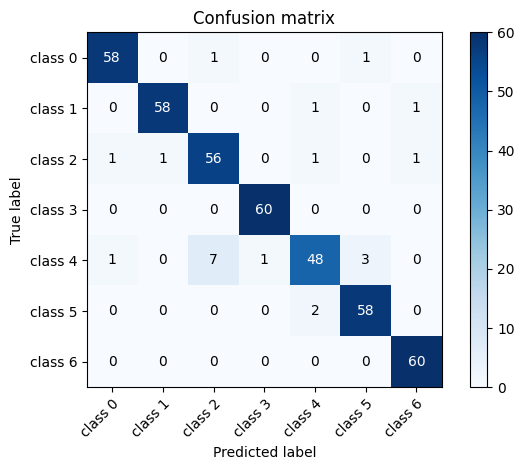

Recall: 0.9476190476190477
Precision: 0.9478038287185543
F1 score: 0.9468552875608288
              precision    recall  f1-score   support

     class 0       0.97      0.97      0.97        60
     class 1       0.98      0.97      0.97        60
     class 2       0.88      0.93      0.90        60
     class 3       0.98      1.00      0.99        60
     class 4       0.92      0.80      0.86        60
     class 5       0.94      0.97      0.95        60
     class 6       0.97      1.00      0.98        60

    accuracy                           0.95       420
   macro avg       0.95      0.95      0.95       420
weighted avg       0.95      0.95      0.95       420



In [19]:

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

# Initialize lists to store the true and predicted labels
true_labels = []
pred_labels = []

# Test the model
model.eval()
test_correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()

        # Store the true and predicted labels for confusion matrix
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

print(f"Test Accuracy: {test_correct / len(test_loader.dataset)}")

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:")

np.set_printoptions(precision=2)

# Create a heatmap from the confusion matrix
class_names = ['class 0', 'class 1', 'class 2', 'class 3','class 4','class 5','class 6'] # change this to match your dataset
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, format(cm[i, j], fmt),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

# Compute recall, precision, and F1 score
recall = recall_score(true_labels, pred_labels, average='macro')
precision = precision_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 score: {f1}")

# Compute classification report
target_names = ['class 0', 'class 1', 'class 2', 'class 3','class 4','class 5','class 6'] # change this to match your dataset
report = classification_report(true_labels, pred_labels, target_names=target_names)
print(report)


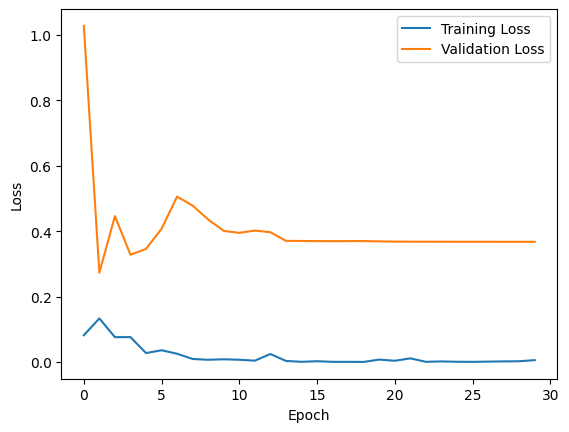

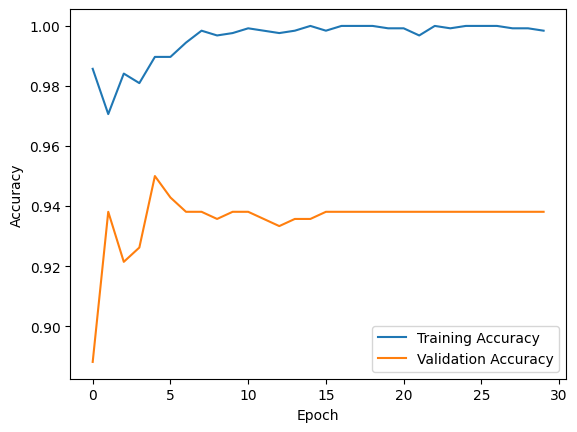

In [16]:
# Plot the training and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure()
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()